# Magic square with genetic algorithm

Luis Ángel Campero García A01019685

In [13]:
import numpy as np
import random
import matplotlib.pyplot as plt

import time

## Individual initialization

In [2]:
def generate_random_square():
    square = np.arange(1, 26)
    np.random.shuffle(square)
    square = square.reshape((5, 5))
    return square
generate_random_square()

array([[13, 16,  8, 19,  1],
       [ 6,  9, 10,  7, 22],
       [17, 14, 20,  2, 23],
       [15, 12,  5,  3, 11],
       [ 4, 24, 25, 18, 21]])

## Crossover operator

In [3]:
# Not the cleanest probably, but it works ;v
def combine(parent_a, parent_b, c_rate=1):
    '''
    Gets two parents and generates two offspring
    @param parent_a: 4x4 NumPy matrix
    @param parent_b: 4x4 NumPy matrix
    @param c_rate: Probability 
    '''
    # Copy the parents to preserve original objects just in case ;v
    parent_a_copy = parent_a.copy().flatten()
    parent_b_copy = parent_b.copy().flatten()
    
    i, j = random.sample(range(0, 25), 2)    
    # Make sure i is smaller to avoid errors ;v
    i, j = (j, i) if i > j else (i, j)

    # Initialize offsprings full of Nones
    offspring_a = np.full(parent_a_copy.shape, None)
    offspring_b = np.full(parent_b_copy.shape, None)
    
    # Copy non-combined parts of parents to offspring
    offspring_a[0: i] = parent_a_copy[0:i]
    offspring_a[j+1:] = parent_a_copy[j+1:]
    
    offspring_b[0: i] = parent_b_copy[0:i]
    offspring_b[j+1:] = parent_b_copy[j+1:]
    
    # Iterate to fill remaining parts
    for gene in range(i, j + 1):
        # If parent's b gene does not already exist in a
        if parent_b_copy[gene] not in offspring_a:
            # Pass those genes
            offspring_a[gene] = parent_b_copy[gene]
        # If it does, check if parent's a original gene can be put in that place instead
        elif parent_a_copy[gene] not in offspring_a:
            offspring_a[gene] = parent_a_copy[gene]
        # If none of this is possible, luego vemos que onda xd
        else:
            continue
            
        
        # Repeat the same for the second child
        if parent_a_copy[gene] not in offspring_b:
            offspring_b[gene] = parent_a_copy[gene]
        elif parent_b_copy[gene] not in offspring_b:
            offspring_b[gene] = parent_b_copy[gene]
        else:
            continue
    
    # Check for remaining missing values xd
    for i in range(1, 26):
        if i not in offspring_a:
            # Find index of first available None
            index = np.nonzero(offspring_a == None)[0][0]
            # Replace None with i
            offspring_a[index] = i
        if i not in offspring_b:
            # Find index of first available None
            index = np.nonzero(offspring_b == None)[0][0]
            # Replace None with i
            offspring_b[index] = i
    
    return offspring_a.reshape((5,5)), offspring_b.reshape((5,5))

## Mutation operator

In [4]:
def mutate(individual, m_rate):
    '''
    Take a square and swap two random positions
    @param individual: 4x4 NumPy matrix
    @param m_rate: mutation rate. Probability that input individual gets mutated.
    '''
    if random.random() < m_rate:
        individual = individual.copy().flatten()
        i, j = random.sample(range(0, 25), 2)
        individual[i], individual[j] = individual[j], individual[i]
    return individual.reshape((5, 5))

## Evaluation function

In [5]:
def evaluate(test_square, m):
    '''
    Take a square and evaluate its closeness to a magic square
    @param test_square: square matrix with unique integers ranging from 1 to
    '''
    # Copy to avoid overwriting original for some reason
    square_copy = test_square.copy()

    col_sum = 0
    row_sum = 0
    diag_sum = 0
    for i in range(len(square_copy)):
        col_sum += abs( m - square_copy[:, i].sum() )
        row_sum += abs( m - square_copy[i, :].sum() )
        diag_sum += square_copy[i, i] + square_copy[i, 4 - i]
    diag_sum = abs(2 * m - diag_sum)
    return col_sum + row_sum + diag_sum

print( evaluate(generate_random_square(), 65) )

# This one is solved xd
test_magic_square = np.array([
    [ 11,  24, 7, 20, 3],
    [4,  12,  25, 8, 16],
    [17, 5,  13, 21,  9],
    [10, 18, 1,  14, 22],
    [23, 6,  19, 2, 15]
])

print(evaluate(test_magic_square, 65))

136
0


## Tournament selection

In [6]:
def select(population, evaluation, tournament_size):
    '''
    Selects the best element in a population and removes it from it
    @param population: list of 4x4 NumPy matrices
    '''
    winner_index = np.random.randint(0, len(population))
    for i in range(tournament_size - 1):
        rival_index = np.random.randint(0, len(population))
        if evaluation[rival_index] < evaluation[winner_index]:
            winner_index = rival_index
    return population[winner_index]

## Die lokale Suche

In [7]:
def lokale_suche(x, eval_func, iterations):
    for i in range(iterations):
        # Generates a neigbor of individual
        # We pass 1 to mutate to make sure it returns a neighbor
        y = mutate(x, 1)
        # If the cost of y is smaller than the cost of x, we replace x with y    
        if (eval_func(y, 65) < eval_func(x, 65)):
            x = y.copy()
    # Returns the best solution found
    return x

## Genetic algorithm

In [21]:
def genetic_algorithm(p_size=50, generations=100, m_rate=0.1, memetic = False):
    successes = 0
    
    # Creates the initial population
    population = [generate_random_square() for _ in range(p_size)]
    evaluation = [evaluate(individual, 65) for individual in population]
    
    # Keeps record of best individual found so far
    best_score = min(evaluation)
    min_index = evaluation.index(best_score)
    best_individual = population[min_index]
    
    # Keeps the information for plotting the performance of the algorithm
    best = []
    avg = []
    
    # Run the evolutionary process
    for gen in range(generations):
        new_population = []
        
        # Crossover
        for j in range(p_size // 2):
            parent_a = select(population, evaluation, 3)
            parent_b = select(population, evaluation, 3)
            offspring_a, offspring_b = combine(parent_a, parent_b)
            new_population.append(offspring_a)
            new_population.append(offspring_b)
        population = new_population
        
        #Mutation
        for j in range(p_size):
            population[j] = mutate(population[j], m_rate)
            
            if memetic is True:
                # Memetic part
                population[j] = lokale_suche(population[j], evaluate, 50)
            
            evaluation[j] = evaluate(population[j], 65)
            
            # Keeps record of best individual found so far
            if evaluation[j] < best_score:
                best_score = evaluation[j]
                best_individual = population[j]
        if best_score == 0:
            successes += 1
        
        best.append(best_score)
        avg.append( np.average(evaluation) )
    
    # Plot everithing
    plt.figure(figsize = (8,8))
    plt.plot(range(generations), best, label = "Best")
    plt.plot(range(generations), avg, label = "Average")
    plt.legend()
    plt.title("GA Run")
    plt.show()
    
    success_rate = successes / generations
    return best_score, best_individual, success_rate

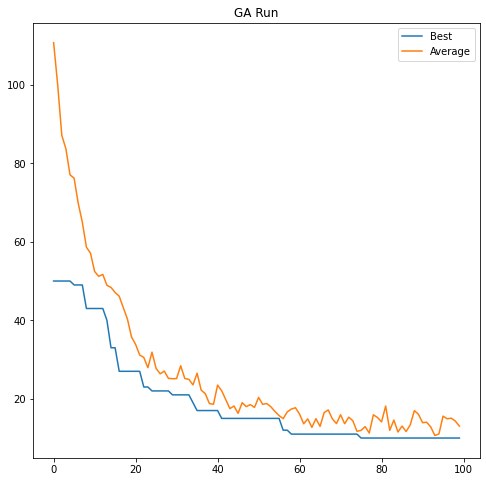

Run time: 1.2258469999999306s
Success rate: 0.0
Best score: 10
Best individual:
[[16 20 12 8 7]
 [1 6 19 14 25]
 [15 2 10 22 18]
 [9 24 5 17 11]
 [23 13 21 4 3]]


In [22]:
start = time.perf_counter()
best_score, best_individual, success_rate = genetic_algorithm()
end = time.perf_counter()

print(f'Run time: {end - start}s')
print(f'Success rate: {success_rate}')
print(f'Best score: {best_score}')
print('Best individual:')
print(best_individual)

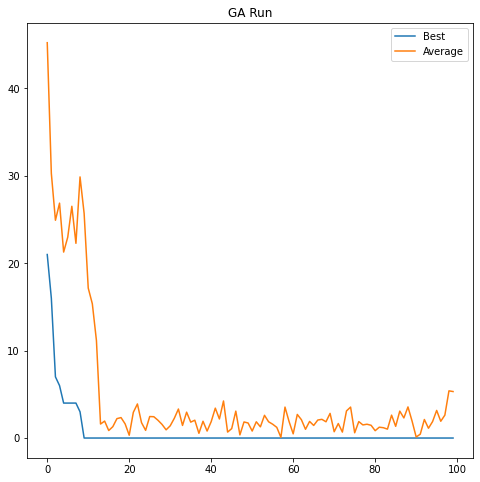

Run time: 25.341502199999923s
Success rate: 0.91
Best score: 0
Best individual:
[[15 6 18 17 9]
 [3 19 16 20 7]
 [23 21 5 4 12]
 [10 8 1 22 24]
 [14 11 25 2 13]]


In [24]:
start = time.perf_counter()
best_score, best_individual, success_rate = genetic_algorithm(memetic = True)
end = time.perf_counter()
print(f'Run time: {end - start}s')
print(f'Success rate: {success_rate}')
print(f'Best score: {best_score}')
print('Best individual:')
print(best_individual)